In [172]:
#率変化(MGG(ルーレット))
import random
import math
import numpy as np
import pandas as pd
type(np.int32(np.atleast_1d(np.int32(0))))
from operator import attrgetter
import matplotlib.pyplot as plt
from IPython.display import clear_output
print('ok')

ok


In [115]:
wavedate=pd.read_csv("BLUEJAY_20170603.csv", encoding="shift_jis")#
wavedata=wavedate.values
print(np.shape(wavedata))
def main():
    n_gene   = 52   # The number of genes.
    n_ind    = 50  #the number of individuals in a population.
    CXPB     = 0.85   # The probability of crossover.
    MUTPB    = 1.0   # The probability of individdual mutation.
    NGEN     = 4000   # The number of generation loop.
    n_parents=2     #非復元抽出の個体数
    MUTINDPB = 0.0050  # The probability of gene mutation.
    CXPB_MAX =0.900   #交叉率の最大値
    CXPB_MIN =0.200   #交叉率の最小値
    M_MAX    =10.0/52.0  #突然変異率の最大値
    M_MIN    =1.0/52.0/2  #突然変異率の最小値
    f        =15.0

    random.seed()
    # --- Step1 : 母集団作成.
    pop = create_pop(n_ind, n_gene)
    set_fitness(evalOneMax, pop)  #各個体について評価
    fit_sum = keisan(n_ind,pop)  #適応度の合計値を計算
    best_ind = min(pop, key=attrgetter("fitness"))  #最良個体の適応度

    # --- 世代分の繰り返し.
    print("Generation loop start.")
    print("Generation: 0. Best fitness: " + str(best_ind.fitness))
    for g in range(NGEN):     
        # --- Step2 : 選択.
        parents,pop = randomselection(n_ind,pop,n_parents)
        fit_sum=fit_sum-parents[0].fitness-parents[1].fitness
        children = parents
  
        # --- Step3 : 交叉.
        crossover = []
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CXPB:
                child1, child2 = cxTwoPointCopy(child1, child2)
                child1.fitness = None
                child2.fitness = None
            crossover.append(child1)
            crossover.append(child2)
        children = crossover[:]


        # --- Step4 : 突然変異.
        mutant = []
        for mut in (children):
            if random.random() < MUTPB:
                mut = mutFlipBit(mut, indpb=MUTINDPB)
                mut.fitness = None
            mutant.append(mut)

        children = mutant[:]
        set_fitness(evalOneMax, children)

        
         #-----Step5 : 生存選択
        family = children+parents
        offspring = []
        
        family_sorted = sorted(family, key=attrgetter("fitness"))
        for i in range(int(n_parents/2)):
            worst_ind = max(family_sorted[int(n_parents/2):], key=attrgetter("fitness"))
            C_max     = worst_ind.fitness
            offspring = roulette(family_sorted[int(n_parents/2):],C_max)
            #offspring.append(random.choice(family))
        offspring = offspring+family_sorted[:int(n_parents/2)]

        
        # --- 次世代を現世代に更新.
        pop = pop + offspring
        fit_sum = fit_sum+offspring[0].fitness+offspring[1].fitness
        fitness_mean =fit_sum/n_gene #,fit_var
        # --- Print best fitness in the population.
        best_ind = min(pop, key=attrgetter("fitness"))
        f_max = best_ind.fitness
        CXPB,MUTINDPB = adjustrating(CXPB,MUTINDPB,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean)
        print("Generation: " + str(g+1) + ". Best fitness: " + str(best_ind.fitness)+ " mean: "+str(int(fitness_mean))+" MU: "+str(MUTINDPB))#+" CXPB: "+str(CXPB))  #+" variance: " + str(int(fit_var))
        #if best_ind.fitness <= 0.0 :
            #break
    lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2=get_parameter_from_ind(best_ind)   
    print("Generation loop ended. The best individual: ")
    print(best_ind)
    print("Hv1",Hv_1,"theta1",theta_1,"lambda1",lambda_1,"w1",omega_1)
    print("Hv2",Hv_2,"theta2",theta_2,"lambda2",lambda_2,"w2",omega_2)
   
class Individual(np.ndarray):
    """Container of a individual."""
    fitness = None
    
    def __new__(cls, a):
        return np.asarray(a).view(cls)

def create_ind(n_gene):
    """Create a individual."""
    return Individual([random.randint(0, 1) for i in range(n_gene)])

def create_pop(n_ind, n_gene):
    """Create a population."""
    pop = []
    for i in range(n_ind):
        ind = create_ind(n_gene)
        pop.append(ind)
    return pop

def set_fitness(eval_func, pop):
    """Set fitnesses of each individual in a population."""
    for i, fit in zip(range(len(pop)), map(eval_func, pop)):
        pop[i].fitness = fit
    
def evalOneMax(ind):
    """Objective function."""
    errorfunc=0.0
    lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2 = get_parameter_from_ind(ind)
   
    for j in range(36):
        theta_func=j*10#wavedate[0][j+1]
        for i in range(25):
            omega_func=wavedata[i][0]*2*math.pi
            HL1=Hv_1/(1.56*4*math.pi**2/omega_1**2)
            """波集中度s1の周波数依存"""
            if HL1<0.026:
                if HL1>=0.009:
                    S_max1=12.99*10**(0.4444*math.log10(HL1)*(-2.5)+0.5849*(-2.5))
                else:
                    S_max1=84
            elif HL1>=0.026:
                if HL1<=0.05:
                    S_max1=10**(-3.913*math.log10(HL1)-4.79)
                else:
                    S_max1=1.98 
    
            if omega_func<=omega_1:
                s_1=math.ceil(S_max1*omega_func**5/omega_1**5)
            else:
                s_1=math.ceil(S_max1*omega_func**(-2.5)/omega_1**(-2.5))
            
            """波集中度s2の周波数依存"""
            HL2=Hv_2/(1.56*4*math.pi**2/omega_2**2)
            if HL2<0.026:
                if HL2>=0.009:
                    S_max2=12.99*10**(0.4444*math.log10(HL2)*(-2.5)+0.5849*(-2.5))
                else:
                    S_max2=84
            elif HL2>=0.026:
                if HL2<=0.05:
                    S_max2=10**(-3.913*math.log10(HL2)-4.79)
                else:
                    S_max2=1.98      
            
            if omega_func<=omega_2:
                s_2=math.ceil(S_max2*omega_func**5/omega_2**5)
            else:
                s_2=math.ceil(S_max2*omega_func**(-2.5)/omega_2**(-2.5))

            spectrum_11=0.250*((4.0*lambda_1+1.0)/4.0*omega_1**4.0)**lambda_1
            spectrum_12=math.gamma(lambda_1)
            spectrum_16=Hv_1**2.0
            spectrum_13=omega_func**(4.0*lambda_1+1.0)
            spectrum_14=(math.gamma(s_1+1.0))**2.0
            spectrum_18=math.pi*math.gamma(2.0*s_1+1.0)
            spectrum_17=2.0**(2.0*s_1-1.0)
            spectrum_15=abs((math.cos((theta_func-theta_1)/2.0*math.pi/180.0)))**(2.0*s_1)*math.exp(-(4.0*lambda_1+1.0)/4.0*(omega_1/omega_func)**4.0)
            spectrum_1=spectrum_11/spectrum_13*spectrum_14*spectrum_15*spectrum_16/spectrum_12*spectrum_17/spectrum_18
            spectrum_21=0.250*((4.0*lambda_2+1.0)/4.0*omega_2**4.0)**lambda_2
            spectrum_22=math.gamma(lambda_2)
            spectrum_26=Hv_2**2.0
            spectrum_23=omega_func**(4.0*lambda_2+1.0)
            spectrum_24=(math.gamma(s_2+1.0))**2.0
            spectrum_28=math.pi*math.gamma(2.0*s_2+1.0)
            spectrum_27=2.0**(2.0*s_2-1.0)
            spectrum_25=abs((math.cos((theta_func-theta_2)/2.0*math.pi/180.0)))**(2.0*s_2)*math.exp(-(4.0*lambda_2+1.0)/4.0*(omega_2/omega_func)**4.0)
            spectrum_2=spectrum_21/spectrum_23*spectrum_24*spectrum_25*spectrum_26/spectrum_22*spectrum_27/spectrum_28
            if i==0:
                df=wavedata[1][0]-wavedata[0][0]
            elif i==24:
                df=wavedata[24][0]-wavedata[23][0]
            else:
                df=(wavedata[i+1][0]-wavedata[i-1][0])/2
            E=((wavedata[i][j+1]-2*math.pi*(spectrum_1+spectrum_2)))**2.0
            if wavedata[i][j+1]>2*math.pi*(spectrum_1+spectrum_2):
                errorfunc +=E#+E*wavedate[i+1][j+1]
            else:
                errorfunc +=E#+E*2*math.pi*(spectrum_1+spectrum_2)
    return errorfunc

def adjustrating(C_p,M_p,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean):
    cross_para = 1.0/f-1/abs(f_max-fitness_mean)
    if (C_p*(1+cross_para))<=CXPB_MIN:
        C_p = CXPB_MIN
    else:
        if (C_p*(1+cross_para))<=CXPB_MAX:
            C_p = C_p*(1+cross_para)
        else:
            C_p = CXPB_MAX       
                                  
    M_para = 1/abs(f_max-fitness_mean) - 1/f
    if (M_p*(1+M_para))<=M_MIN:
        M_p = M_MIN
    else:
        if (M_p*(1+M_para))<=M_MAX:
            M_p = M_p*(1+M_para)
        else:
            M_p = M_MAX
         
    return  C_p,M_p

def randomselection(n_ind,pop,n_parents):
    chosen=[]    
    for i in range(n_parents):
        idx=random.randrange(0, n_ind-i)
        chosen.append(pop[idx])
        pop.pop(idx)
    return chosen,pop
    """chosen = []   
    eve1=random.randrange(0, n_ind, 2)
    odd1=random.randrange(1, n_ind, 2)
    chosen.append(pop[eve1])
    chosen.append(pop[odd1])
    if eve1>odd1:
        pop.pop(eve1)
        pop.pop(odd1)
    else:
        pop.pop(odd1)
        pop.pop(eve1) 
    return chosen,pop"""


def tournament(pop, n_ind, tournsize):
    """#Selection function."""
    chosen = []    
    for i in range(n_ind):
        aspirants = [random.choice(pop) for j in range(tournsize)]
        chosen.append(min(aspirants, key=attrgetter("fitness")))
    return chosen

def roulette(pop,C_max):
    """Selection function."""
    chosen=[]
    fitness_sum=0.0
    for i in range(len(pop)):
        fitness_sum += C_max- pop[i].fitness
        
    sigma_fitness = 0.0
    s = random.random()*fitness_sum
    for i in range(len(pop)):
        sigma_fitness += C_max-pop[i].fitness
        if (sigma_fitness)>=s:
            chosen.append(pop[i])
            break
    #chosens=chosen[:]
    #print("chosens"+str(len(chosens)))
    return chosen

def cxTwoPointCopy(ind1, ind2):
    """Crossover function."""
    size = len(ind1)
    tmp1 = ind1.copy()
    tmp2 = ind2.copy()
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size-1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    tmp1[cxpoint1:cxpoint2], tmp2[cxpoint1:cxpoint2] = tmp2[cxpoint1:cxpoint2].copy(), tmp1[cxpoint1:cxpoint2].copy()
    return tmp1, tmp2

def evalchild(offspring,n_ind):
    fit_mean = 0.0
    fit_var  = 0.0
    for i in range(n_ind):
        fit_mean += offspring[i].fitness/n_ind
    for k in range(n_ind):
        fit_var += (offspring[k].fitness - fit_mean)**2/n_ind
    return fit_mean, fit_var

def mutFlipBit(ind, indpb):
    """Mutation function."""
    tmp = ind.copy()
    for i in range(len(ind)):
        if random.random() < indpb:
            tmp[i] = type(ind[i])(not ind[i])
    return tmp

def keisan(n_ind,pop):
    Ex=0.0
    #Var=0.0
    for i in range(n_ind):
        Ex += pop[i].fitness
    #for i in range(n_ind):
        #Var += (pop[i].fitness-Ex)**2/n_ind
    return Ex#,Var
        
def get_parameter_from_ind2(ind):
    lambda_1 = (1.0*ind[0]+2*ind[10]+4*ind[20]+8*ind[30]+16*ind[40])*0.10+0.10
    theta_1  = (1.0*ind[1]+2*ind[11]+4*ind[21]+8*ind[31]+16*ind[41]+32*ind[50]+64*ind[56])*2.8125
    s_1      = (1.0*ind[2]+2*ind[12]+4*ind[22]+8*ind[32]+16*ind[42])+1.0
    omega_1  = (1.0*ind[3]+2*ind[13]+4*ind[23]+8*ind[33]+16*ind[43]+32*ind[51])*0.015+0.20
    Hv_1     = (1.0*ind[4]+2*ind[14]+4*ind[24]+8*ind[34]+16*ind[44]+32.0*ind[52]+64.0*ind[57]+128.0*ind[60])*0.040+1.0
    lambda_2 = (1.0*ind[5]+2*ind[15]+4*ind[25]+8*ind[35]+16*ind[45])*0.10+0.10
    theta_2  = (1.0*ind[6]+2*ind[16]+4*ind[26]+8*ind[36]+16*ind[46]+32*ind[53]+64*ind[58])*2.8125
    s_2      = (1.0*ind[7]+2*ind[17]+4*ind[27]+8*ind[37]+16*ind[47])+1.0
    omega_2  = (1.0*ind[8]+2*ind[18]+4*ind[28]+8*ind[38]+16*ind[48]+32*ind[54])*0.040+0.20
    Hv_2     = (1.0*ind[9]+2.0*ind[19]+4.0*ind[29]+8.0*ind[39]+16.0*ind[49]+32.0*ind[55]+64.0*ind[59]+128.0*ind[61])*0.040+1.0# print("Generation loop ended. The best individual: ")
   #print("Hv1",Hv_1,"s1",s_1,"theta1",theta_1,"lambda1",lambda_1,"w1",omega_1)
    #print("Hv2",Hv_2,"s2",s_2,"theta2",theta_2,"lambda2",lambda_2,"w2",omega_2)
    # print(" fitness_mean "+str(fitness_mean)+" variance: " + str(fit_var))
    return lambda_1, s_1, theta_1, omega_1, Hv_1, lambda_2, s_2, theta_2, omega_2,Hv_2

def get_parameter_from_ind(ind):
    Hv_1     =(1.0*ind[0]+2*ind[1]+4*ind[2]+8*ind[3]+16*ind[4]+32.0*ind[5]+64.0*ind[6]+128.0*ind[7])*0.020+0.2
    lambda_1 =(1.0*ind[8]+2*ind[9]+4*ind[10]+8*ind[11]+16*ind[12])*0.10+0.10
    theta_1  =(1.0*ind[13]+2*ind[14]+4*ind[15]+8*ind[16]+16*ind[17]+32*ind[18]+64*ind[19])*2.8125
    #s_1      =(1.0*ind[2]+2*ind[12]+4*ind[22]+8*ind[32]+16*ind[42])+1.0
    omega_1  =(1.0*ind[20]+2*ind[21]+4*ind[22]+8*ind[23]+16*ind[24]+32*ind[25])*0.010+0.30 
    lambda_2 =(1.0*ind[26]+2*ind[27]+4*ind[28]+8*ind[29]+16*ind[30])*0.10+0.10
    theta_2  =(1.0*ind[31]+2*ind[32]+4*ind[33]+8*ind[34]+16*ind[35]+32*ind[36]+64*ind[37])*2.8125
    #s_2      =(1.0*ind[7]+2*ind[17]+4*ind[27]+8*ind[37]+16*ind[47])+1.0
    omega_2  =(1.0*ind[38]+2*ind[39]+4*ind[40]+8*ind[41]+16*ind[42]+32*ind[43])*0.010+0.30
    Hv_2     =(1.0*ind[44]+2.0*ind[45]+4.0*ind[46]+8.0*ind[47]+16.0*ind[48]+32.0*ind[49]+64.0*ind[50]+128.0*ind[51])*0.020+0.2
    return lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2


if __name__ == "__main__":

    main()

(25, 38)
Generation loop start.
Generation: 0. Best fitness: 194.57505188167067
Generation: 1. Best fitness: 194.57505188167067 mean: 10080 MU: 0.009615384615384616
Generation: 2. Best fitness: 194.57505188167067 mean: 10055 MU: 0.009615384615384616
Generation: 3. Best fitness: 194.57505188167067 mean: 9350 MU: 0.009615384615384616
Generation: 4. Best fitness: 194.57505188167067 mean: 9322 MU: 0.009615384615384616
Generation: 5. Best fitness: 194.57505188167067 mean: 9080 MU: 0.009615384615384616
Generation: 6. Best fitness: 194.57505188167067 mean: 8954 MU: 0.009615384615384616
Generation: 7. Best fitness: 183.50981913821812 mean: 8904 MU: 0.009615384615384616
Generation: 8. Best fitness: 183.50981913821812 mean: 8903 MU: 0.009615384615384616
Generation: 9. Best fitness: 183.50981913821812 mean: 8815 MU: 0.009615384615384616
Generation: 10. Best fitness: 183.50981913821812 mean: 8745 MU: 0.009615384615384616
Generation: 11. Best fitness: 183.50981913821812 mean: 8192 MU: 0.00961538461

Generation: 99. Best fitness: 59.48805477584349 mean: 319 MU: 0.009615384615384616
Generation: 100. Best fitness: 59.48805477584349 mean: 319 MU: 0.009615384615384616
Generation: 101. Best fitness: 59.48805477584349 mean: 316 MU: 0.009615384615384616
Generation: 102. Best fitness: 59.48805477584349 mean: 315 MU: 0.009615384615384616
Generation: 103. Best fitness: 59.48805477584349 mean: 313 MU: 0.009615384615384616
Generation: 104. Best fitness: 59.48805477584349 mean: 308 MU: 0.009615384615384616
Generation: 105. Best fitness: 59.48805477584349 mean: 300 MU: 0.009615384615384616
Generation: 106. Best fitness: 59.48805477584349 mean: 269 MU: 0.009615384615384616
Generation: 107. Best fitness: 59.48805477584349 mean: 263 MU: 0.009615384615384616
Generation: 108. Best fitness: 59.48805477584349 mean: 263 MU: 0.009615384615384616
Generation: 109. Best fitness: 59.48805477584349 mean: 260 MU: 0.009615384615384616
Generation: 110. Best fitness: 59.48805477584349 mean: 260 MU: 0.009615384615

Generation: 199. Best fitness: 31.61542452801968 mean: 141 MU: 0.009615384615384616
Generation: 200. Best fitness: 31.61542452801968 mean: 138 MU: 0.009615384615384616
Generation: 201. Best fitness: 31.61542452801968 mean: 138 MU: 0.009615384615384616
Generation: 202. Best fitness: 31.61542452801968 mean: 138 MU: 0.009615384615384616
Generation: 203. Best fitness: 31.61542452801968 mean: 137 MU: 0.009615384615384616
Generation: 204. Best fitness: 31.61542452801968 mean: 137 MU: 0.009615384615384616
Generation: 205. Best fitness: 31.61542452801968 mean: 136 MU: 0.009615384615384616
Generation: 206. Best fitness: 31.61542452801968 mean: 136 MU: 0.009615384615384616
Generation: 207. Best fitness: 31.61542452801968 mean: 135 MU: 0.009615384615384616
Generation: 208. Best fitness: 31.61542452801968 mean: 130 MU: 0.009615384615384616
Generation: 209. Best fitness: 31.61542452801968 mean: 130 MU: 0.009615384615384616
Generation: 210. Best fitness: 31.61542452801968 mean: 130 MU: 0.00961538461

Generation: 299. Best fitness: 23.325287217249603 mean: 93 MU: 0.009615384615384616
Generation: 300. Best fitness: 23.325287217249603 mean: 91 MU: 0.009615384615384616
Generation: 301. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 302. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 303. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 304. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 305. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 306. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 307. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 308. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 309. Best fitness: 23.325287217249603 mean: 90 MU: 0.009615384615384616
Generation: 310. Best fitness: 23.325287217249603 mean: 90 MU: 0.00961538461

Generation: 400. Best fitness: 23.091337351182222 mean: 50 MU: 0.009615384615384616
Generation: 401. Best fitness: 23.091337351182222 mean: 50 MU: 0.009615384615384616
Generation: 402. Best fitness: 23.091337351182222 mean: 49 MU: 0.009615384615384616
Generation: 403. Best fitness: 23.091337351182222 mean: 49 MU: 0.009615384615384616
Generation: 404. Best fitness: 23.091337351182222 mean: 49 MU: 0.009615384615384616
Generation: 405. Best fitness: 23.091337351182222 mean: 49 MU: 0.009615384615384616
Generation: 406. Best fitness: 23.091337351182222 mean: 48 MU: 0.009615384615384616
Generation: 407. Best fitness: 23.091337351182222 mean: 48 MU: 0.009615384615384616
Generation: 408. Best fitness: 23.091337351182222 mean: 48 MU: 0.009615384615384616
Generation: 409. Best fitness: 23.091337351182222 mean: 48 MU: 0.009615384615384616
Generation: 410. Best fitness: 23.091337351182222 mean: 48 MU: 0.009615384615384616
Generation: 411. Best fitness: 23.091337351182222 mean: 48 MU: 0.00961538461

Generation: 499. Best fitness: 22.852737282463764 mean: 31 MU: 0.030501497192830452
Generation: 500. Best fitness: 22.852737282463764 mean: 31 MU: 0.031830345618698824
Generation: 501. Best fitness: 22.852737282463764 mean: 31 MU: 0.0332170875350988
Generation: 502. Best fitness: 22.852737282463764 mean: 31 MU: 0.03466424516817798
Generation: 503. Best fitness: 22.852737282463764 mean: 31 MU: 0.03617445062905864
Generation: 504. Best fitness: 22.852737282463764 mean: 32 MU: 0.037717445716793065
Generation: 505. Best fitness: 22.852737282463764 mean: 31 MU: 0.03936342097634962
Generation: 506. Best fitness: 22.852737282463764 mean: 34 MU: 0.04006831654457506
Generation: 507. Best fitness: 22.852737282463764 mean: 34 MU: 0.04083051129146348
Generation: 508. Best fitness: 22.852737282463764 mean: 34 MU: 0.041607204796530024
Generation: 509. Best fitness: 21.610834702290116 mean: 34 MU: 0.04208361841402384
Generation: 510. Best fitness: 21.610834702290116 mean: 34 MU: 0.04257201504700597
G

Generation: 600. Best fitness: 19.844964703437892 mean: 32 MU: 0.0388840375188919
Generation: 601. Best fitness: 19.844964703437892 mean: 32 MU: 0.039322090817417825
Generation: 602. Best fitness: 19.844964703437892 mean: 32 MU: 0.039701789489916726
Generation: 603. Best fitness: 19.844964703437892 mean: 33 MU: 0.04004025123744012
Generation: 604. Best fitness: 19.844964703437892 mean: 33 MU: 0.040381598405394396
Generation: 605. Best fitness: 19.844964703437892 mean: 33 MU: 0.040725855592278856
Generation: 606. Best fitness: 19.844964703437892 mean: 33 MU: 0.04108226047466267
Generation: 607. Best fitness: 19.844964703437892 mean: 32 MU: 0.0414887943950596
Generation: 608. Best fitness: 19.844964703437892 mean: 32 MU: 0.04189935121552395
Generation: 609. Best fitness: 19.844964703437892 mean: 34 MU: 0.041977100826737154
Generation: 610. Best fitness: 19.844964703437892 mean: 34 MU: 0.042054994712309474
Generation: 611. Best fitness: 19.844964703437892 mean: 34 MU: 0.042133033139960446

Generation: 702. Best fitness: 11.436269178398833 mean: 24 MU: 0.04606977056413859
Generation: 703. Best fitness: 11.436269178398833 mean: 24 MU: 0.04659942717006487
Generation: 704. Best fitness: 11.436269178398833 mean: 24 MU: 0.04713517315123149
Generation: 705. Best fitness: 11.436269178398833 mean: 23 MU: 0.048067784642384905
Generation: 706. Best fitness: 11.436269178398833 mean: 23 MU: 0.049018848684686075
Generation: 707. Best fitness: 11.436269178398833 mean: 23 MU: 0.04998873037833706
Generation: 708. Best fitness: 11.436269178398833 mean: 23 MU: 0.05097780204737343
Generation: 709. Best fitness: 11.436269178398833 mean: 22 MU: 0.05203798375687957
Generation: 710. Best fitness: 11.436269178398833 mean: 22 MU: 0.05312021398970428
Generation: 711. Best fitness: 11.436269178398833 mean: 23 MU: 0.05415884442632073
Generation: 712. Best fitness: 11.436269178398833 mean: 22 MU: 0.05526093580509156
Generation: 713. Best fitness: 11.436269178398833 mean: 22 MU: 0.0564030713498606
Gen

Generation: 801. Best fitness: 11.253225472690508 mean: 24 MU: 0.056423747661395095
Generation: 802. Best fitness: 11.253225472690508 mean: 24 MU: 0.05692321072524484
Generation: 803. Best fitness: 11.253225472690508 mean: 23 MU: 0.057754301174177514
Generation: 804. Best fitness: 11.253225472690508 mean: 23 MU: 0.05859752571262318
Generation: 805. Best fitness: 11.253225472690508 mean: 23 MU: 0.05935011600347529
Generation: 806. Best fitness: 11.253225472690508 mean: 23 MU: 0.060100855858085514
Generation: 807. Best fitness: 11.253225472690508 mean: 23 MU: 0.06101328387041833
Generation: 808. Best fitness: 11.253225472690508 mean: 23 MU: 0.061939564012904756
Generation: 809. Best fitness: 11.253225472690508 mean: 23 MU: 0.06287990658324193
Generation: 810. Best fitness: 11.253225472690508 mean: 24 MU: 0.06334722050544622
Generation: 811. Best fitness: 11.253225472690508 mean: 24 MU: 0.06381800743379433
Generation: 812. Best fitness: 11.253225472690508 mean: 24 MU: 0.06421825911029665


Generation: 900. Best fitness: 11.253225472690508 mean: 26 MU: 0.0403487329409098
Generation: 901. Best fitness: 11.253225472690508 mean: 26 MU: 0.04035951209033237
Generation: 902. Best fitness: 11.253225472690508 mean: 27 MU: 0.04010623244735694
Generation: 903. Best fitness: 11.253225472690508 mean: 28 MU: 0.03981162917155838
Generation: 904. Best fitness: 11.253225472690508 mean: 33 MU: 0.0389323683521412
Generation: 905. Best fitness: 11.253225472690508 mean: 33 MU: 0.03808652641830442
Generation: 906. Best fitness: 11.253225472690508 mean: 33 MU: 0.03726914961390578
Generation: 907. Best fitness: 11.253225472690508 mean: 31 MU: 0.036642306341427074
Generation: 908. Best fitness: 11.253225472690508 mean: 31 MU: 0.036039117678528375
Generation: 909. Best fitness: 11.253225472690508 mean: 31 MU: 0.03544585842781403
Generation: 910. Best fitness: 11.253225472690508 mean: 30 MU: 0.03495603711072559
Generation: 911. Best fitness: 11.253225472690508 mean: 30 MU: 0.03447581218478632
Gene

Generation: 1000. Best fitness: 11.253225472690508 mean: 20 MU: 0.03933046604239053
Generation: 1001. Best fitness: 11.253225472690508 mean: 20 MU: 0.04111892587722535
Generation: 1002. Best fitness: 11.253225472690508 mean: 20 MU: 0.04298896022929229
Generation: 1003. Best fitness: 11.253225472690508 mean: 20 MU: 0.044937813335586954
Generation: 1004. Best fitness: 11.253225472690508 mean: 20 MU: 0.04697501536703953
Generation: 1005. Best fitness: 11.253225472690508 mean: 19 MU: 0.04948875435349585
Generation: 1006. Best fitness: 11.253225472690508 mean: 19 MU: 0.052137009180823264
Generation: 1007. Best fitness: 11.253225472690508 mean: 19 MU: 0.05492697809495852
Generation: 1008. Best fitness: 11.253225472690508 mean: 19 MU: 0.05786624453620824
Generation: 1009. Best fitness: 11.253225472690508 mean: 19 MU: 0.060962797751868185
Generation: 1010. Best fitness: 11.253225472690508 mean: 23 MU: 0.061812584817507454
Generation: 1011. Best fitness: 11.253225472690508 mean: 23 MU: 0.062648

Generation: 1100. Best fitness: 10.900038369525081 mean: 35 MU: 0.012519069638577181
Generation: 1101. Best fitness: 10.900038369525081 mean: 34 MU: 0.012213329603862356
Generation: 1102. Best fitness: 10.900038369525081 mean: 34 MU: 0.011915056335570762
Generation: 1103. Best fitness: 10.900038369525081 mean: 34 MU: 0.01162406748074077
Generation: 1104. Best fitness: 10.900038369525081 mean: 34 MU: 0.011342991470464865
Generation: 1105. Best fitness: 10.900038369525081 mean: 34 MU: 0.011075841947671436
Generation: 1106. Best fitness: 10.900038369525081 mean: 34 MU: 0.010815611248665322
Generation: 1107. Best fitness: 10.900038369525081 mean: 28 MU: 0.010714878474213062
Generation: 1108. Best fitness: 10.900038369525081 mean: 24 MU: 0.01081278101250283
Generation: 1109. Best fitness: 10.900038369525081 mean: 24 MU: 0.010913825942612594
Generation: 1110. Best fitness: 10.900038369525081 mean: 24 MU: 0.011015815132842771
Generation: 1111. Best fitness: 10.900038369525081 mean: 24 MU: 0.0

Generation: 1199. Best fitness: 10.900038369525081 mean: 31 MU: 0.041735768707353196
Generation: 1200. Best fitness: 10.900038369525081 mean: 29 MU: 0.04114345912351445
Generation: 1201. Best fitness: 10.900038369525081 mean: 22 MU: 0.04193923609107016
Generation: 1202. Best fitness: 10.900038369525081 mean: 22 MU: 0.04275040459340644
Generation: 1203. Best fitness: 10.900038369525081 mean: 22 MU: 0.04365509181440187
Generation: 1204. Best fitness: 10.900038369525081 mean: 22 MU: 0.044578924093218786
Generation: 1205. Best fitness: 10.900038369525081 mean: 22 MU: 0.0455223065789855
Generation: 1206. Best fitness: 10.900038369525081 mean: 22 MU: 0.04648565299462612
Generation: 1207. Best fitness: 10.900038369525081 mean: 22 MU: 0.047469385818299854
Generation: 1208. Best fitness: 10.900038369525081 mean: 22 MU: 0.04847393646867993
Generation: 1209. Best fitness: 10.900038369525081 mean: 23 MU: 0.04906765479264737
Generation: 1210. Best fitness: 10.900038369525081 mean: 23 MU: 0.04966864

Generation: 1297. Best fitness: 10.900038369525081 mean: 27 MU: 0.027956695972354742
Generation: 1298. Best fitness: 10.900038369525081 mean: 27 MU: 0.027776956236986762
Generation: 1299. Best fitness: 10.900038369525081 mean: 27 MU: 0.027598372087833334
Generation: 1300. Best fitness: 10.900038369525081 mean: 27 MU: 0.02742093609537702
Generation: 1301. Best fitness: 10.900038369525081 mean: 27 MU: 0.02724117251611435
Generation: 1302. Best fitness: 10.900038369525081 mean: 27 MU: 0.027063964379008158
Generation: 1303. Best fitness: 10.900038369525081 mean: 27 MU: 0.02692583597005464
Generation: 1304. Best fitness: 10.900038369525081 mean: 27 MU: 0.026790542383572986
Generation: 1305. Best fitness: 10.900038369525081 mean: 27 MU: 0.02665664578396023
Generation: 1306. Best fitness: 10.900038369525081 mean: 27 MU: 0.02652341838690154
Generation: 1307. Best fitness: 10.900038369525081 mean: 22 MU: 0.02700665706734354
Generation: 1308. Best fitness: 10.900038369525081 mean: 22 MU: 0.02749

Generation: 1396. Best fitness: 10.900038369525081 mean: 35 MU: 0.05911250755847706
Generation: 1397. Best fitness: 10.900038369525081 mean: 35 MU: 0.057566043820209266
Generation: 1398. Best fitness: 10.900038369525081 mean: 35 MU: 0.05606003768038477
Generation: 1399. Best fitness: 10.900038369525081 mean: 35 MU: 0.05459343071310499
Generation: 1400. Best fitness: 10.900038369525081 mean: 33 MU: 0.05335484427218971
Generation: 1401. Best fitness: 10.900038369525081 mean: 33 MU: 0.05214435821536058
Generation: 1402. Best fitness: 10.900038369525081 mean: 34 MU: 0.05092471393197537
Generation: 1403. Best fitness: 10.900038369525081 mean: 34 MU: 0.04973359684173061
Generation: 1404. Best fitness: 10.900038369525081 mean: 48 MU: 0.04775097251085528
Generation: 1405. Best fitness: 10.900038369525081 mean: 46 MU: 0.045893679379826025
Generation: 1406. Best fitness: 10.900038369525081 mean: 46 MU: 0.04410862788270006
Generation: 1407. Best fitness: 10.900038369525081 mean: 46 MU: 0.04239300

Generation: 1497. Best fitness: 10.80431472898822 mean: 91 MU: 0.045417188562921124
Generation: 1498. Best fitness: 10.80431472898822 mean: 91 MU: 0.04295065935388044
Generation: 1499. Best fitness: 10.80431472898822 mean: 91 MU: 0.04061808309374637
Generation: 1500. Best fitness: 10.80431472898822 mean: 89 MU: 0.03842883317642977
Generation: 1501. Best fitness: 10.80431472898822 mean: 53 MU: 0.03676700587130511
Generation: 1502. Best fitness: 10.80431472898822 mean: 51 MU: 0.03521652192347397
Generation: 1503. Best fitness: 10.80431472898822 mean: 50 MU: 0.033757551522963156
Generation: 1504. Best fitness: 10.80431472898822 mean: 50 MU: 0.03235936067189866
Generation: 1505. Best fitness: 10.80431472898822 mean: 50 MU: 0.031019080941984956
Generation: 1506. Best fitness: 10.80431472898822 mean: 49 MU: 0.029743072816795686
Generation: 1507. Best fitness: 10.80431472898822 mean: 49 MU: 0.02852843724770447
Generation: 1508. Best fitness: 10.80431472898822 mean: 49 MU: 0.027361745457518353

Generation: 1596. Best fitness: 10.62473742321438 mean: 16 MU: 0.017259992705929435
Generation: 1597. Best fitness: 10.62473742321438 mean: 16 MU: 0.018870885608289176
Generation: 1598. Best fitness: 10.62473742321438 mean: 16 MU: 0.02063212480494263
Generation: 1599. Best fitness: 10.62473742321438 mean: 16 MU: 0.02255581459163875
Generation: 1600. Best fitness: 10.62473742321438 mean: 16 MU: 0.02465886459597723
Generation: 1601. Best fitness: 10.62473742321438 mean: 16 MU: 0.026957997934073365
Generation: 1602. Best fitness: 10.62473742321438 mean: 16 MU: 0.029471496945243005
Generation: 1603. Best fitness: 10.62473742321438 mean: 16 MU: 0.03221934857023066
Generation: 1604. Best fitness: 10.62473742321438 mean: 20 MU: 0.0332850624418102
Generation: 1605. Best fitness: 10.62473742321438 mean: 20 MU: 0.03438602674850021
Generation: 1606. Best fitness: 10.62473742321438 mean: 20 MU: 0.03552392146402345
Generation: 1607. Best fitness: 10.62473742321438 mean: 21 MU: 0.03656047538253098
G

Generation: 1696. Best fitness: 10.62473742321438 mean: 30 MU: 0.01852990862334701
Generation: 1697. Best fitness: 10.62473742321438 mean: 30 MU: 0.0182259635814212
Generation: 1698. Best fitness: 10.62473742321438 mean: 30 MU: 0.0179492097925434
Generation: 1699. Best fitness: 10.62473742321438 mean: 30 MU: 0.017676668224062723
Generation: 1700. Best fitness: 10.62473742321438 mean: 29 MU: 0.017412872768678835
Generation: 1701. Best fitness: 10.62473742321438 mean: 29 MU: 0.017153511218355667
Generation: 1702. Best fitness: 10.62473742321438 mean: 29 MU: 0.016898012810816557
Generation: 1703. Best fitness: 10.62473742321438 mean: 29 MU: 0.016651785782277297
Generation: 1704. Best fitness: 10.62473742321438 mean: 29 MU: 0.016409728318781753
Generation: 1705. Best fitness: 10.62473742321438 mean: 29 MU: 0.016171148563881903
Generation: 1706. Best fitness: 10.62473742321438 mean: 29 MU: 0.01593603750135418
Generation: 1707. Best fitness: 10.62473742321438 mean: 29 MU: 0.01570449543197655

Generation: 1795. Best fitness: 10.62473742321438 mean: 63 MU: 0.014987668811809102
Generation: 1796. Best fitness: 10.62473742321438 mean: 63 MU: 0.014272709114339576
Generation: 1797. Best fitness: 10.62473742321438 mean: 63 MU: 0.013591855279190877
Generation: 1798. Best fitness: 10.62473742321438 mean: 63 MU: 0.012943480347740352
Generation: 1799. Best fitness: 10.62473742321438 mean: 63 MU: 0.01232603497249082
Generation: 1800. Best fitness: 10.62473742321438 mean: 63 MU: 0.011737946114992834
Generation: 1801. Best fitness: 10.62473742321438 mean: 61 MU: 0.01118424976159903
Generation: 1802. Best fitness: 10.62473742321438 mean: 60 MU: 0.010661332400017072
Generation: 1803. Best fitness: 10.62473742321438 mean: 60 MU: 0.010162899148326167
Generation: 1804. Best fitness: 10.62473742321438 mean: 59 MU: 0.009695120685918187
Generation: 1805. Best fitness: 10.62473742321438 mean: 57 MU: 0.009615384615384616
Generation: 1806. Best fitness: 10.62473742321438 mean: 57 MU: 0.0096153846153

Generation: 1894. Best fitness: 10.62473742321438 mean: 119 MU: 0.03713373715547742
Generation: 1895. Best fitness: 10.62473742321438 mean: 119 MU: 0.03499874026013714
Generation: 1896. Best fitness: 10.62473742321438 mean: 119 MU: 0.03298653019848955
Generation: 1897. Best fitness: 10.62473742321438 mean: 119 MU: 0.031090012394701827
Generation: 1898. Best fitness: 10.62473742321438 mean: 116 MU: 0.029311161113884154
Generation: 1899. Best fitness: 10.62473742321438 mean: 56 MU: 0.02800105699370913
Generation: 1900. Best fitness: 10.62473742321438 mean: 56 MU: 0.026749509844342285
Generation: 1901. Best fitness: 10.62473742321438 mean: 56 MU: 0.025554868463997207
Generation: 1902. Best fitness: 10.62473742321438 mean: 56 MU: 0.024413580137070214
Generation: 1903. Best fitness: 10.62473742321438 mean: 56 MU: 0.023323318247314113
Generation: 1904. Best fitness: 10.62473742321438 mean: 50 MU: 0.02234793312533923
Generation: 1905. Best fitness: 10.62473742321438 mean: 50 MU: 0.02141333877

Generation: 1996. Best fitness: 10.58541466237156 mean: 62 MU: 0.05517559570335443
Generation: 1997. Best fitness: 10.58541466237156 mean: 64 MU: 0.05252831224838011
Generation: 1998. Best fitness: 10.58541466237156 mean: 64 MU: 0.05000804345634951
Generation: 1999. Best fitness: 10.58541466237156 mean: 62 MU: 0.047628427772666106
Generation: 2000. Best fitness: 10.58541466237156 mean: 62 MU: 0.04536582558472279
Generation: 2001. Best fitness: 10.58541466237156 mean: 62 MU: 0.04321976212458141
Generation: 2002. Best fitness: 10.58541466237156 mean: 62 MU: 0.041175219761336035
Generation: 2003. Best fitness: 10.58541466237156 mean: 62 MU: 0.039227395965468606
Generation: 2004. Best fitness: 10.58541466237156 mean: 63 MU: 0.03735253310174826
Generation: 2005. Best fitness: 10.58541466237156 mean: 63 MU: 0.03556727880549062
Generation: 2006. Best fitness: 10.58541466237156 mean: 63 MU: 0.03386735025925974
Generation: 2007. Best fitness: 10.58541466237156 mean: 63 MU: 0.032248746097139826


Generation: 2096. Best fitness: 10.58541466237156 mean: 22 MU: 0.11308228454853303
Generation: 2097. Best fitness: 10.58541466237156 mean: 22 MU: 0.11466026378154323
Generation: 2098. Best fitness: 10.58541466237156 mean: 22 MU: 0.1162602625419246
Generation: 2099. Best fitness: 10.58541466237156 mean: 23 MU: 0.1176765401168648
Generation: 2100. Best fitness: 10.58541466237156 mean: 23 MU: 0.11911007072500329
Generation: 2101. Best fitness: 10.58541466237156 mean: 23 MU: 0.12056106454205691
Generation: 2102. Best fitness: 10.58541466237156 mean: 23 MU: 0.12202973430409413
Generation: 2103. Best fitness: 10.58541466237156 mean: 23 MU: 0.12351629533872516
Generation: 2104. Best fitness: 10.58541466237156 mean: 23 MU: 0.125020965596672
Generation: 2105. Best fitness: 10.58541466237156 mean: 23 MU: 0.12654396568372311
Generation: 2106. Best fitness: 10.58541466237156 mean: 23 MU: 0.12808551889307726
Generation: 2107. Best fitness: 10.58541466237156 mean: 23 MU: 0.12964585123808145
Generati

Generation: 2196. Best fitness: 10.522369924247252 mean: 28 MU: 0.03669232224370981
Generation: 2197. Best fitness: 10.522369924247252 mean: 28 MU: 0.036302618714763986
Generation: 2198. Best fitness: 10.388286633531177 mean: 28 MU: 0.03590258870130449
Generation: 2199. Best fitness: 10.388286633531177 mean: 28 MU: 0.035507247937782045
Generation: 2200. Best fitness: 10.388286633531177 mean: 28 MU: 0.03510909777582723
Generation: 2201. Best fitness: 10.388286633531177 mean: 28 MU: 0.034715412154513306
Generation: 2202. Best fitness: 10.388286633531177 mean: 28 MU: 0.03432791603541067
Generation: 2203. Best fitness: 10.388286633531177 mean: 28 MU: 0.03394483107856347
Generation: 2204. Best fitness: 10.388286633531177 mean: 28 MU: 0.03360687349892065
Generation: 2205. Best fitness: 10.388286633531177 mean: 28 MU: 0.03327228065323022
Generation: 2206. Best fitness: 10.388286633531177 mean: 29 MU: 0.03280237720040483
Generation: 2207. Best fitness: 10.388286633531177 mean: 28 MU: 0.0323788

Generation: 2294. Best fitness: 10.388286633531177 mean: 52 MU: 0.039359607404550905
Generation: 2295. Best fitness: 10.388286633531177 mean: 49 MU: 0.03773549220832386
Generation: 2296. Best fitness: 10.388286633531177 mean: 49 MU: 0.03617839369098551
Generation: 2297. Best fitness: 10.388286633531177 mean: 49 MU: 0.03468432215723852
Generation: 2298. Best fitness: 10.388286633531177 mean: 49 MU: 0.03324960250301747
Generation: 2299. Best fitness: 10.388286633531177 mean: 49 MU: 0.031876250987831214
Generation: 2300. Best fitness: 10.388286633531177 mean: 49 MU: 0.030559624793920402
Generation: 2301. Best fitness: 10.388286633531177 mean: 49 MU: 0.029297430168240723
Generation: 2302. Best fitness: 10.388286633531177 mean: 49 MU: 0.028089850976729273
Generation: 2303. Best fitness: 10.388286633531177 mean: 49 MU: 0.026938278426026866
Generation: 2304. Best fitness: 10.388286633531177 mean: 49 MU: 0.025834630576630033
Generation: 2305. Best fitness: 10.388286633531177 mean: 49 MU: 0.024

Generation: 2392. Best fitness: 9.639714337813459 mean: 40 MU: 0.12359575692029091
Generation: 2393. Best fitness: 9.639714337813459 mean: 40 MU: 0.11939757006129417
Generation: 2394. Best fitness: 9.639714337813459 mean: 40 MU: 0.11534198334766019
Generation: 2395. Best fitness: 9.639714337813459 mean: 40 MU: 0.11141789223045814
Generation: 2396. Best fitness: 9.639714337813459 mean: 40 MU: 0.10762730402909976
Generation: 2397. Best fitness: 9.639714337813459 mean: 40 MU: 0.10397823464262936
Generation: 2398. Best fitness: 9.639714337813459 mean: 65 MU: 0.0989236501609046
Generation: 2399. Best fitness: 9.639714337813459 mean: 65 MU: 0.09411477887454908
Generation: 2400. Best fitness: 9.639714337813459 mean: 65 MU: 0.08953967618661386
Generation: 2401. Best fitness: 9.639714337813459 mean: 66 MU: 0.08515796628403847
Generation: 2402. Best fitness: 9.639714337813459 mean: 66 MU: 0.08098950866643534
Generation: 2403. Best fitness: 9.639714337813459 mean: 73 MU: 0.07685542605777514
Gener

Generation: 2492. Best fitness: 9.639714337813459 mean: 40 MU: 0.01444649779701292
Generation: 2493. Best fitness: 9.639714337813459 mean: 40 MU: 0.013952226134587272
Generation: 2494. Best fitness: 9.639714337813459 mean: 40 MU: 0.013474918292735278
Generation: 2495. Best fitness: 9.639714337813459 mean: 40 MU: 0.013013933807609611
Generation: 2496. Best fitness: 9.639714337813459 mean: 40 MU: 0.012569218748810038
Generation: 2497. Best fitness: 9.639714337813459 mean: 40 MU: 0.012137353105832388
Generation: 2498. Best fitness: 9.639714337813459 mean: 40 MU: 0.011721324546379025
Generation: 2499. Best fitness: 9.639714337813459 mean: 40 MU: 0.011319556078131024
Generation: 2500. Best fitness: 9.639714337813459 mean: 40 MU: 0.010931554353007746
Generation: 2501. Best fitness: 9.639714337813459 mean: 40 MU: 0.010557014809011122
Generation: 2502. Best fitness: 9.639714337813459 mean: 40 MU: 0.010195307828937907
Generation: 2503. Best fitness: 9.639714337813459 mean: 40 MU: 0.009846054757

Generation: 2591. Best fitness: 9.639714337813459 mean: 26 MU: 0.03125913341003444
Generation: 2592. Best fitness: 9.639714337813459 mean: 26 MU: 0.03106482030955494
Generation: 2593. Best fitness: 9.639714337813459 mean: 26 MU: 0.030871715098639195
Generation: 2594. Best fitness: 9.639714337813459 mean: 25 MU: 0.0307228319476165
Generation: 2595. Best fitness: 9.639714337813459 mean: 25 MU: 0.030618937685637886
Generation: 2596. Best fitness: 9.639714337813459 mean: 25 MU: 0.030515394759033903
Generation: 2597. Best fitness: 9.639714337813459 mean: 25 MU: 0.030381525332986718
Generation: 2598. Best fitness: 9.639714337813459 mean: 26 MU: 0.030111524767290294
Generation: 2599. Best fitness: 9.639714337813459 mean: 26 MU: 0.029843923696177416
Generation: 2600. Best fitness: 9.639714337813459 mean: 26 MU: 0.029578700795343665
Generation: 2601. Best fitness: 9.639714337813459 mean: 26 MU: 0.02931583492999368
Generation: 2602. Best fitness: 9.639714337813459 mean: 26 MU: 0.0290553051531569

Generation: 2692. Best fitness: 9.639714337813459 mean: 28 MU: 0.056573733693762444
Generation: 2693. Best fitness: 9.639714337813459 mean: 28 MU: 0.0557880059596282
Generation: 2694. Best fitness: 9.639714337813459 mean: 28 MU: 0.05501319085281902
Generation: 2695. Best fitness: 9.639714337813459 mean: 28 MU: 0.054249136812647966
Generation: 2696. Best fitness: 9.639714337813459 mean: 28 MU: 0.05349226369245049
Generation: 2697. Best fitness: 9.639714337813459 mean: 28 MU: 0.052819327709491735
Generation: 2698. Best fitness: 9.639714337813459 mean: 28 MU: 0.05215485730278461
Generation: 2699. Best fitness: 9.639714337813459 mean: 28 MU: 0.05150959197873862
Generation: 2700. Best fitness: 9.639714337813459 mean: 24 MU: 0.051564501726099596
Generation: 2701. Best fitness: 9.639714337813459 mean: 25 MU: 0.051373017297834125
Generation: 2702. Best fitness: 9.639714337813459 mean: 25 MU: 0.05115985795334608
Generation: 2703. Best fitness: 9.639714337813459 mean: 25 MU: 0.050947583059655986

Generation: 2794. Best fitness: 8.69003473934448 mean: 24 MU: 0.04997639472448483
Generation: 2795. Best fitness: 8.69003473934448 mean: 24 MU: 0.04980616606922466
Generation: 2796. Best fitness: 8.69003473934448 mean: 22 MU: 0.050114865504612895
Generation: 2797. Best fitness: 8.69003473934448 mean: 22 MU: 0.05042547826417221
Generation: 2798. Best fitness: 8.69003473934448 mean: 22 MU: 0.05077262617693675
Generation: 2799. Best fitness: 8.69003473934448 mean: 22 MU: 0.05112171257668689
Generation: 2800. Best fitness: 8.69003473934448 mean: 22 MU: 0.05147319911453637
Generation: 2801. Best fitness: 8.69003473934448 mean: 22 MU: 0.051827102292597266
Generation: 2802. Best fitness: 8.69003473934448 mean: 22 MU: 0.052183438726441676
Generation: 2803. Best fitness: 8.69003473934448 mean: 21 MU: 0.05267932978909594
Generation: 2804. Best fitness: 8.69003473934448 mean: 21 MU: 0.05317993322701756
Generation: 2805. Best fitness: 8.69003473934448 mean: 21 MU: 0.05368650750378806
Generation: 2

Generation: 2896. Best fitness: 7.835500708818008 mean: 17 MU: 0.045592212929447866
Generation: 2897. Best fitness: 7.835500708818008 mean: 17 MU: 0.047271251233429054
Generation: 2898. Best fitness: 7.835500708818008 mean: 17 MU: 0.049012123992136065
Generation: 2899. Best fitness: 7.835500708818008 mean: 17 MU: 0.050817108401855715
Generation: 2900. Best fitness: 7.835500708818008 mean: 17 MU: 0.052688565521875654
Generation: 2901. Best fitness: 7.835500708818008 mean: 17 MU: 0.05462894336293263
Generation: 2902. Best fitness: 7.835500708818008 mean: 17 MU: 0.056605931761756774
Generation: 2903. Best fitness: 7.835500708818008 mean: 17 MU: 0.0586544661742594
Generation: 2904. Best fitness: 7.835500708818008 mean: 17 MU: 0.06077713580737583
Generation: 2905. Best fitness: 7.835500708818008 mean: 17 MU: 0.06297662356987338
Generation: 2906. Best fitness: 7.835500708818008 mean: 17 MU: 0.06525570946336395
Generation: 2907. Best fitness: 7.835500708818008 mean: 19 MU: 0.06670302169295499

Generation: 2995. Best fitness: 7.835500708818008 mean: 40 MU: 0.009615384615384616
Generation: 2996. Best fitness: 7.835500708818008 mean: 40 MU: 0.009615384615384616
Generation: 2997. Best fitness: 7.835500708818008 mean: 40 MU: 0.009615384615384616
Generation: 2998. Best fitness: 7.835500708818008 mean: 40 MU: 0.009615384615384616
Generation: 2999. Best fitness: 7.835500708818008 mean: 40 MU: 0.009615384615384616
Generation: 3000. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3001. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3002. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3003. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3004. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3005. Best fitness: 7.835500708818008 mean: 39 MU: 0.009615384615384616
Generation: 3006. Best fitness: 7.835500708818008 mean: 39 MU: 0.00961538461

Generation: 3096. Best fitness: 7.835500708818008 mean: 126 MU: 0.06110698200291432
Generation: 3097. Best fitness: 7.835500708818008 mean: 126 MU: 0.057547776378122875
Generation: 3098. Best fitness: 7.835500708818008 mean: 126 MU: 0.05419587840074466
Generation: 3099. Best fitness: 7.835500708818008 mean: 126 MU: 0.051039290821024666
Generation: 3100. Best fitness: 7.835500708818008 mean: 126 MU: 0.048066539909529
Generation: 3101. Best fitness: 7.835500708818008 mean: 127 MU: 0.045265033645602026
Generation: 3102. Best fitness: 7.835500708818008 mean: 123 MU: 0.042639590111794856
Generation: 3103. Best fitness: 7.835500708818008 mean: 121 MU: 0.04017284652769145
Generation: 3104. Best fitness: 7.835500708818008 mean: 121 MU: 0.037848725203799435
Generation: 3105. Best fitness: 7.835500708818008 mean: 121 MU: 0.03565906136537453
Generation: 3106. Best fitness: 7.835500708818008 mean: 121 MU: 0.03359607623804197
Generation: 3107. Best fitness: 7.835500708818008 mean: 121 MU: 0.0316524

Generation: 3195. Best fitness: 7.769286049048886 mean: 17 MU: 0.06059933788093562
Generation: 3196. Best fitness: 7.769286049048886 mean: 17 MU: 0.06284601565757407
Generation: 3197. Best fitness: 7.769286049048886 mean: 17 MU: 0.06517598743062479
Generation: 3198. Best fitness: 7.769286049048886 mean: 16 MU: 0.06805197292532526
Generation: 3199. Best fitness: 7.769286049048886 mean: 23 MU: 0.06788860375254391
Generation: 3200. Best fitness: 7.769286049048886 mean: 23 MU: 0.06772563682486976
Generation: 3201. Best fitness: 7.769286049048886 mean: 23 MU: 0.06756306110010815
Generation: 3202. Best fitness: 7.769286049048886 mean: 23 MU: 0.06740087563917455
Generation: 3203. Best fitness: 7.769286049048886 mean: 23 MU: 0.06723907950523872
Generation: 3204. Best fitness: 7.769286049048886 mean: 23 MU: 0.06707767176371929
Generation: 3205. Best fitness: 7.769286049048886 mean: 23 MU: 0.06691690391508621
Generation: 3206. Best fitness: 7.769286049048886 mean: 23 MU: 0.06675652138544938
Gene

Generation: 3294. Best fitness: 7.68734623495508 mean: 37 MU: 0.013189938836639459
Generation: 3295. Best fitness: 7.68734623495508 mean: 37 MU: 0.01275595849074314
Generation: 3296. Best fitness: 7.68734623495508 mean: 37 MU: 0.012337018125628778
Generation: 3297. Best fitness: 7.68734623495508 mean: 37 MU: 0.011931901474874525
Generation: 3298. Best fitness: 7.68734623495508 mean: 37 MU: 0.011542061168614587
Generation: 3299. Best fitness: 7.68734623495508 mean: 36 MU: 0.011170120026337061
Generation: 3300. Best fitness: 7.68734623495508 mean: 36 MU: 0.010810235382670806
Generation: 3301. Best fitness: 7.68734623495508 mean: 30 MU: 0.010573804196874585
Generation: 3302. Best fitness: 7.68734623495508 mean: 29 MU: 0.010345129918605034
Generation: 3303. Best fitness: 7.68734623495508 mean: 29 MU: 0.010122679409289608
Generation: 3304. Best fitness: 7.68734623495508 mean: 29 MU: 0.009919590308071782
Generation: 3305. Best fitness: 7.68734623495508 mean: 29 MU: 0.009721370380503802
Gener

Generation: 3395. Best fitness: 7.585685314839039 mean: 32 MU: 0.049550659248921575
Generation: 3396. Best fitness: 7.585685314839039 mean: 32 MU: 0.04824050727517677
Generation: 3397. Best fitness: 7.585685314839039 mean: 32 MU: 0.04696499658008145
Generation: 3398. Best fitness: 7.585685314839039 mean: 32 MU: 0.045723097631330555
Generation: 3399. Best fitness: 7.585685314839039 mean: 33 MU: 0.044467549227195924
Generation: 3400. Best fitness: 7.585685314839039 mean: 33 MU: 0.04324647796649186
Generation: 3401. Best fitness: 7.585685314839039 mean: 33 MU: 0.042049430177565274
Generation: 3402. Best fitness: 7.585685314839039 mean: 33 MU: 0.04088551626395876
Generation: 3403. Best fitness: 7.585685314839039 mean: 33 MU: 0.03975450455828273
Generation: 3404. Best fitness: 7.585685314839039 mean: 32 MU: 0.038691971859948444
Generation: 3405. Best fitness: 7.585685314839039 mean: 32 MU: 0.03765499264532746
Generation: 3406. Best fitness: 7.585685314839039 mean: 29 MU: 0.03689107942356885

Generation: 3495. Best fitness: 7.585685314839039 mean: 11 MU: 0.06238279959406302
Generation: 3496. Best fitness: 7.585685314839039 mean: 11 MU: 0.07288044672671444
Generation: 3497. Best fitness: 7.585685314839039 mean: 11 MU: 0.0851446159782634
Generation: 3498. Best fitness: 7.585685314839039 mean: 11 MU: 0.09947257399876216
Generation: 3499. Best fitness: 7.585685314839039 mean: 11 MU: 0.1162116108488323
Generation: 3500. Best fitness: 7.585685314839039 mean: 11 MU: 0.13576745783464392
Generation: 3501. Best fitness: 7.585685314839039 mean: 11 MU: 0.15861412187857155
Generation: 3502. Best fitness: 7.585685314839039 mean: 11 MU: 0.18530537479718975
Generation: 3503. Best fitness: 7.585685314839039 mean: 11 MU: 0.19230769230769232
Generation: 3504. Best fitness: 7.585685314839039 mean: 12 MU: 0.19230769230769232
Generation: 3505. Best fitness: 7.585685314839039 mean: 12 MU: 0.19230769230769232
Generation: 3506. Best fitness: 7.585685314839039 mean: 12 MU: 0.19230769230769232
Genera

Generation: 3594. Best fitness: 7.585685314839039 mean: 23 MU: 0.025270680709414177
Generation: 3595. Best fitness: 7.585685314839039 mean: 22 MU: 0.025260728657570633
Generation: 3596. Best fitness: 7.585685314839039 mean: 17 MU: 0.026115417977280522
Generation: 3597. Best fitness: 7.585685314839039 mean: 17 MU: 0.026999025458581415
Generation: 3598. Best fitness: 7.585685314839039 mean: 17 MU: 0.027897199617465673
Generation: 3599. Best fitness: 7.585685314839039 mean: 17 MU: 0.028830957781449444
Generation: 3600. Best fitness: 7.585685314839039 mean: 17 MU: 0.02979597013297756
Generation: 3601. Best fitness: 7.585685314839039 mean: 17 MU: 0.030793282793280054
Generation: 3602. Best fitness: 7.585685314839039 mean: 17 MU: 0.03186523421843936
Generation: 3603. Best fitness: 7.585685314839039 mean: 17 MU: 0.03283774364998407
Generation: 3604. Best fitness: 7.585685314839039 mean: 17 MU: 0.03383993353477635
Generation: 3605. Best fitness: 7.585685314839039 mean: 20 MU: 0.034240647458213

Generation: 3693. Best fitness: 7.576997491036831 mean: 10 MU: 0.06160762984601513
Generation: 3694. Best fitness: 7.576997491036831 mean: 10 MU: 0.08071692078765617
Generation: 3695. Best fitness: 7.576997491036831 mean: 10 MU: 0.10058463560696138
Generation: 3696. Best fitness: 7.576997491036831 mean: 10 MU: 0.12534260253560625
Generation: 3697. Best fitness: 7.576997491036831 mean: 10 MU: 0.15619451137437573
Generation: 3698. Best fitness: 7.576997491036831 mean: 10 MU: 0.19230769230769232
Generation: 3699. Best fitness: 7.576997491036831 mean: 11 MU: 0.19230769230769232
Generation: 3700. Best fitness: 7.576997491036831 mean: 11 MU: 0.19230769230769232
Generation: 3701. Best fitness: 7.576997491036831 mean: 14 MU: 0.19230769230769232
Generation: 3702. Best fitness: 7.576997491036831 mean: 14 MU: 0.19230769230769232
Generation: 3703. Best fitness: 7.576997491036831 mean: 19 MU: 0.19230769230769232
Generation: 3704. Best fitness: 7.576997491036831 mean: 19 MU: 0.19230769230769232
Gene

Generation: 3793. Best fitness: 7.576997491036831 mean: 22 MU: 0.06142119514226911
Generation: 3794. Best fitness: 7.576997491036831 mean: 22 MU: 0.061349239254402
Generation: 3795. Best fitness: 7.576997491036831 mean: 20 MU: 0.06191333319260611
Generation: 3796. Best fitness: 7.576997491036831 mean: 20 MU: 0.06248261386132206
Generation: 3797. Best fitness: 7.576997491036831 mean: 21 MU: 0.06283899994912118
Generation: 3798. Best fitness: 7.576997491036831 mean: 21 MU: 0.06319741877908211
Generation: 3799. Best fitness: 7.576997491036831 mean: 21 MU: 0.06353693069435391
Generation: 3800. Best fitness: 7.576997491036831 mean: 21 MU: 0.06387826655026821
Generation: 3801. Best fitness: 7.576997491036831 mean: 21 MU: 0.06422143614547805
Generation: 3802. Best fitness: 7.576997491036831 mean: 21 MU: 0.06442320355976501
Generation: 3803. Best fitness: 7.576997491036831 mean: 21 MU: 0.06462560487593756
Generation: 3804. Best fitness: 7.576997491036831 mean: 21 MU: 0.06507275807039448
Genera

Generation: 3892. Best fitness: 7.512679534278941 mean: 34 MU: 0.016414887299875867
Generation: 3893. Best fitness: 7.512679534278941 mean: 34 MU: 0.01592936135945866
Generation: 3894. Best fitness: 7.512679534278941 mean: 34 MU: 0.015458207256581286
Generation: 3895. Best fitness: 7.512679534278941 mean: 34 MU: 0.015001031461287588
Generation: 3896. Best fitness: 7.512679534278941 mean: 34 MU: 0.014557654643874908
Generation: 3897. Best fitness: 7.512679534278941 mean: 34 MU: 0.014130867922560804
Generation: 3898. Best fitness: 7.512679534278941 mean: 34 MU: 0.013717228771072957
Generation: 3899. Best fitness: 7.512679534278941 mean: 34 MU: 0.013315866779397384
Generation: 3900. Best fitness: 7.512679534278941 mean: 34 MU: 0.012927611934011487
Generation: 3901. Best fitness: 7.512679534278941 mean: 33 MU: 0.012562477035791615
Generation: 3902. Best fitness: 7.512679534278941 mean: 33 MU: 0.012207650964216176
Generation: 3903. Best fitness: 7.512679534278941 mean: 33 MU: 0.011863317843

Generation: 3993. Best fitness: 7.512679534278941 mean: 16 MU: 0.030118443632047118
Generation: 3994. Best fitness: 7.512679534278941 mean: 18 MU: 0.030955847733911877
Generation: 3995. Best fitness: 7.512679534278941 mean: 18 MU: 0.03182150667860769
Generation: 3996. Best fitness: 7.512679534278941 mean: 18 MU: 0.03271137317901231
Generation: 3997. Best fitness: 7.512679534278941 mean: 18 MU: 0.03361907761071196
Generation: 3998. Best fitness: 7.512679534278941 mean: 18 MU: 0.034454458937712464
Generation: 3999. Best fitness: 7.512679534278941 mean: 18 MU: 0.03531059817989381
Generation: 4000. Best fitness: 7.512679534278941 mean: 18 MU: 0.036122060251957765
Generation loop ended. The best individual: 
[0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0
 1 1 1 1 0 1 1 1 0 0 0 1 0 0 0]
Hv1 2.2 theta1 227.8125 lambda1 1.3000000000000003 w1 0.9199999999999999
Hv2 0.54 theta2 194.0625 lambda2 2.9000000000000004 w2 0.8500000000000001


## リストじゃなくndarrayを使って計算の高速化を図る

Generation: 20000. Best fitness: 1.7927600710065608 mean: 8 MU: 0.1


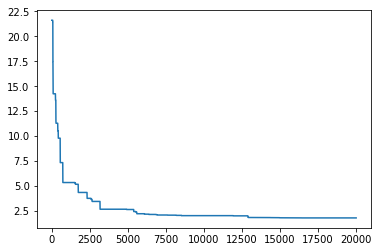

Generation loop ended. The best individual: 
[0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0]
Hv1 2.3800000000000003 theta1 39.375 lambda1 0.13 w1 0.98
Hv2 0.54 theta2 95.625 lambda2 0.97 w2 0.74


In [176]:
wavedate=pd.read_csv("BLUEJAY_20170518.csv", encoding="shift_jis",engine="python")#
wavedata=[[float(wavedate.iloc[i][j+1])for j in range(36)] for i in range(25)]#wavedate.values[0:25,1:37]
#wavedata=[[float(wavedate.iloc[i][j])for j in range(36)] for i in range(25)]
freq=np.array([0.0445953,0.0486315,0.053033,0.0578329,0.0630672,0.0687753,0.075,0.0817881,0.0891906,0.097263,0.106066,0.1156658,0.1261345,0.1375506,0.15,0.1635762,0.1783811,0.194526,0.2121321,0.2313317,0.252269,0.2751013,0.3000001,0.3271524,0.3567623])
print(type(wavedata[0][0]))

def main():
    n_gene   = 64   # The number of genes.
    n_ind    = 64  #the number of individuals in a population.
    CXPB     = 0.85   # The probability of crossover.
    MUTPB    = 1.0   # The probability of individdual mutation.
    NGEN     = 20000   # The number of generation loop.
    n_parents=2     #非復元抽出の個体数
    MUTINDPB = 0.0050  # The probability of gene mutation.
    CXPB_MAX =0.900   #交叉率の最大値
    CXPB_MIN =0.200   #交叉率の最小値
    M_MAX    =0.1#10.0/n_gene  #突然変異率の最大値
    M_MIN    =0.01#1.0/n_gene/2  #突然変異率の最小値
    f        =15
    random.seed()
    
    Loss_Function=[]
    
    """ Step1 : 母集団作成."""
    pop = create_pop(n_ind, n_gene)
    set_fitness(evalOneMax, pop)  #各個体について評価
    fit_sum = keisan(n_ind,pop)  #適応度の合計値を計算
    best_ind = min(pop, key=attrgetter("fitness"))  #最良個体の適応度


    # --- 世代分の繰り返し.
    print("Generation loop start.")
    print("Generation: 0. Best fitness: " + str(best_ind.fitness))
    for g in range(NGEN):     
        """ Step2 : 選択."""
        parents,pop = randomselection(n_ind,pop,n_parents)
        fit_sum=fit_sum-parents[0].fitness-parents[1].fitness
        children = parents.copy()
  
        """ Step3 : 交叉."""
        crossover = []
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CXPB:
                child1, child2 = cxTwoPointCopy(child1, child2)
                child1.fitness = None
                child2.fitness = None
            crossover.append(child1)
            crossover.append(child2)
        children = crossover[:]


        """ Step4 : 突然変異."""
        mutant = []
        for mut in (children):
            if random.random() < MUTPB:
                mut = mutFlipBit(mut, indpb=MUTINDPB)
                mut.fitness = None
            mutant.append(mut)

        children = mutant[:]
        set_fitness(evalOneMax, children)

        
        """Step5 : 生存選択"""
        family = children+parents
        offspring = []
        
        family_sorted = sorted(family, key=attrgetter("fitness")) #ここで，誤差が小さい順に並べる
        offspring=roulette(family_sorted[1:],family_sorted[3].fitness)
        offspring+=family_sorted[:1]

        
        """ 次世代を現世代に更新."""
        pop = pop + offspring
        fit_sum = fit_sum+offspring[0].fitness+offspring[1].fitness
        fitness_mean =fit_sum/n_ind #,fit_var
        """ Print best fitness in the population."""
        best_ind = min(pop, key=attrgetter("fitness"))
        f_max = best_ind.fitness
        CXPB,MUTINDPB = adjustrating(CXPB,MUTINDPB,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean)
        
        Loss_Function.append(best_ind.fitness)
        
        if (g+1) % 100 == 0:
            clear_output(wait=True)
            plt.close()
            print("Generation: " + str(g+1) + ". Best fitness: " + str(best_ind.fitness)+ " mean: "+str(int(fitness_mean))+" MU: "+str(MUTINDPB))#+" CXPB: "+str(CXPB))  #+" variance: " + str(int(fit_var))
            plt.plot(Loss_Function)
            plt.show()
    lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2=get_parameter_from_ind(best_ind)   
    print("Generation loop ended. The best individual: ")
    print(best_ind)
    print("Hv1",Hv_1,"theta1",theta_1,"lambda1",lambda_1,"w1",omega_1)
    print("Hv2",Hv_2,"theta2",theta_2,"lambda2",lambda_2,"w2",omega_2)
   
class Individual(np.ndarray):
    """Container of a individual."""
    fitness = None
    
    def __new__(cls, a):
        return np.asarray(a).view(cls)

def create_ind(n_gene):
    """Create a individual."""
    return Individual([np.random.randint(0,2) for i in range(n_gene)])

def create_pop(n_ind, n_gene):
    """Create a population."""
    pop = []
    for i in range(n_ind):
        ind = create_ind(n_gene)
        pop.append(ind)
    return pop

def set_fitness(eval_func, pop):
    """Set fitnesses of each individual in a population."""
    for i, fit in zip(range(len(pop)), map(eval_func, pop)):
        pop[i].fitness = fit
    
def evalOneMax(ind):
    """Objective function."""
    errorfunc=0.0
    lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2 = get_parameter_from_ind(ind)
    S_max1=def_S_max(Hv_1,omega_1)
    S_max2=def_S_max(Hv_2,omega_2)
   
    for j in range(36):
        theta_func=j*10#wavedate[0][j+1]
        for i in range(25):
            omega=freq[i]*2*math.pi
            """1峰目"""
            if omega<=omega_1:
                s_1=(S_max1*omega**5/omega_1**5)
            else:
                s_1=(S_max1*omega**(-2.5)/omega_1**(-2.5))   
            spectrum_11=0.250*((4.0*lambda_1+1.0)/4.0*omega_1**4.0)**lambda_1
            spectrum_12=math.gamma(lambda_1)
            spectrum_16=Hv_1**2.0
            spectrum_13=omega**(4.0*lambda_1+1.0)
            spectrum_14=2.0**(2.0*s_1-1.0)*(math.gamma(s_1+1.0))**2.0/math.pi/math.gamma(2.0*s_1+1.0)
            spectrum_15=abs((math.cos((theta_func-theta_1)/2.0*math.pi/180.0)))**(2.0*s_1)*math.exp(-(4.0*lambda_1+1.0)/4.0*(omega_1/omega)**4.0)
            spectrum_1=spectrum_11/spectrum_13*spectrum_14*spectrum_15*spectrum_16/spectrum_12
            
            """2峰目"""
            if omega<=omega_2:
                s_2=(S_max2*omega**5/omega_2**5)
            else:
                s_2=(S_max2*omega**(-2.5)/omega_2**(-2.5))      
            spectrum_21=0.250*((4.0*lambda_2+1.0)/4.0*omega_2**4.0)**lambda_2
            spectrum_22=math.gamma(lambda_2)
            spectrum_26=Hv_2**2.0
            spectrum_23=omega**(4.0*lambda_2+1.0)
            spectrum_24=2.0**(2.0*s_2-1.0)*(math.gamma(s_2+1.0))**2.0/math.pi/math.gamma(2.0*s_2+1.0)
            spectrum_25=abs((math.cos((theta_func-theta_2)/2.0*math.pi/180.0)))**(2.0*s_2)*math.exp(-(4.0*lambda_2+1.0)/4.0*(omega_2/omega)**4.0)
            spectrum_2=spectrum_21/spectrum_23*spectrum_24*spectrum_25*spectrum_26/spectrum_22  

            errorfunc +=((wavedata[i][j]-2*math.pi*(spectrum_1+spectrum_2)))**2.0
    return errorfunc

def adjustrating(C_p,M_p,CXPB_MAX,CXPB_MIN,M_MAX,M_MIN,f,f_max,fitness_mean):
    cross_para = 1.0/f-1/abs(f_max-fitness_mean)
    if (C_p*(1+cross_para))<=CXPB_MIN:
        C_p = CXPB_MIN
    else:
        if (C_p*(1+cross_para))<=CXPB_MAX:
            C_p = C_p*(1+cross_para)
        else:
            C_p = CXPB_MAX       
                                  
    M_para = 1/abs(f_max-fitness_mean) - 1/f
    if (M_p*(1+M_para))<=M_MIN:
        M_p = M_MIN
    else:
        if (M_p*(1+M_para))<=M_MAX:
            M_p = M_p*(1+M_para)
        else:
            M_p = M_MAX
         
    return  C_p,M_p

def randomselection(n_ind,pop,n_parents):
    chosen=[]    
    for i in range(n_parents):
        idx=random.randrange(0, n_ind-i)
        chosen.append(pop[idx])
        pop.pop(idx)
    return chosen,pop
    """chosen = []   
    eve1=random.randrange(0, n_ind, 2)
    odd1=random.randrange(1, n_ind, 2)
    chosen.append(pop[eve1])
    chosen.append(pop[odd1])
    if eve1>odd1:
        pop.pop(eve1)
        pop.pop(odd1)
    else:
        pop.pop(odd1)
        pop.pop(eve1) 
    return chosen,pop"""


def tournament(pop, n_ind, tournsize):
    """#Selection function."""
    chosen = []    
    for i in range(n_ind):
        aspirants = [random.choice(pop) for j in range(tournsize)]
        chosen.append(min(aspirants, key=attrgetter("fitness")))
    return chosen

def roulette(pop,C_max):
    """Selection function."""
    chosen=[]
    fitness_sum=0.0
    for i in range(len(pop)):
        fitness_sum += C_max- pop[i].fitness
        
    sigma_fitness = 0.0
    s = random.random()*fitness_sum
    for i in range(len(pop)):
        sigma_fitness += C_max-pop[i].fitness
        if (sigma_fitness)>=s:
            chosen.append(pop[i])
            break
    #chosens=chosen[:]
    #print("chosens"+str(len(chosens)))
    return chosen

def cxTwoPointCopy(ind1, ind2):
    """Crossover function."""
    size = len(ind1)
    tmp1 = ind1.copy()
    tmp2 = ind2.copy()
    cxpoint1 = random.randint(1, size)
    cxpoint2 = random.randint(1, size-1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else: # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    tmp1[cxpoint1:cxpoint2], tmp2[cxpoint1:cxpoint2] = tmp2[cxpoint1:cxpoint2].copy(), tmp1[cxpoint1:cxpoint2].copy()
    return tmp1, tmp2

def evalchild(offspring,n_ind):
    fit_mean = 0.0
    fit_var  = 0.0
    for i in range(n_ind):
        fit_mean += offspring[i].fitness/n_ind
    for k in range(n_ind):
        fit_var += (offspring[k].fitness - fit_mean)**2/n_ind
    return fit_mean, fit_var

def mutFlipBit(ind, indpb):
    """Mutation function."""
    tmp = ind.copy()
    for i in range(len(ind)):
        if random.random() < indpb:
            tmp[i] = type(ind[i])(not ind[i])
    return tmp

def keisan(n_ind,pop):
    Ex=0.0
    #Var=0.0
    for i in range(n_ind):
        Ex += pop[i].fitness
    #for i in range(n_ind):
        #Var += (pop[i].fitness-Ex)**2/n_ind
    return Ex#,Var
        

def get_parameter_from_ind(ind):
    """1峰目"""
    Hv_1     =0.10+0.020*np.sum([ind[i]*2**i for i in range(9)])#0.1<=H<=10.32
    lambda_1 =0.01+0.015*np.sum([ind[i+9]*2**i for i in range(9)])#0.01<=H<=7.675
    theta_1  =2.8125*np.sum([ind[i+18]*2**i for i in range(7)])
    omega_1  =0.35+0.015*np.sum([ind[i+25]*2**i for i in range(7)])#0.35<=omega<=2.255
    """2峰目"""
    Hv_2     =0.020*np.sum([ind[i+32]*2**i for i in range(9)])#0<=H<=10.22
    lambda_2 =0.01+0.015*np.sum([ind[i+41]*2**i for i in range(9)])#0.01<=H<=7.675
    theta_2  =2.8125*np.sum([ind[i+50]*2**i for i in range(7)])
    omega_2  =0.35+0.015*np.sum([ind[i+57]*2**i for i in range(7)])#0.35<=omega<=2.255
    return lambda_1,theta_1,omega_1, Hv_1,lambda_2,theta_2,omega_2,Hv_2

def def_S_max(H,omega_m):
    HL=H/(1.56*4*math.pi**2/omega_m**2)
    """波集中度s1の周波数依存"""
    if H==0:
        S_max=0
    elif HL<0.026:
        log_10=0.4444*math.log10(HL)+0.5849
        a=10**(log_10)
        S_max=12.99*a**(-2.5)
        
    elif HL>=0.026:
        log10_gF=(0.1507-math.sqrt(0.1507**2+4*0.005882*0.8789+4*0.005882*math.log10(HL)))/(2*0.005882)
        gF=10**log10_gF
        gT=1.37*(1-1/(1+0.008*gF**(1/3))**5)
        S_max=12.99*gT**2.5
    
    if S_max >=84:
        S_max=84
    return S_max


if __name__ == "__main__":

    main()

In [52]:
Individual([np.array(random.randint(0, 1)) for i in range(5)])

Individual([1, 1, 0, 0, 0])

In [126]:
0.0445953,0.0486315,0.053033,0.0578329,0.0630672,0.0687753,0.075,0.0817881,0.0891906,0.097263,0.106066,0.1156658,0.1261345,0.1375506,0.15,0.1635762,0.1783811,0.194526,0.2121321,0.2313317,0.252269,0.2751013,0.3000001,0.3271524,0.3567623

0.3567623

a
